<H1 style="text-align: center;">Credit Risk Analysis Project</H1>
<p style="margin:10px; font-size: 15px"> This project aims to use loan data to parameterize a highly accurate logistic regression model, which ideally performs with a "conservative" bias. Because the model is being created from the creditor's perspective, it is best to limit exposure to financial risk by exercising caution in computing whether or not to lend to a debtor. The dataset for the project was taken from a publicly available Kaggle competition and is hosted on Archive.org to reduce the amount of local storage the project consumes. The set contains around 500,000 instances (debitors) and roughly 70 features for each example. </p>



<h3 style="text-align: center; color:#028ad9;">Part 0: Setting up the Enviroment</h3>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

import warnings
warnings.simplefilter(action='ignore')

ModuleNotFoundError: No module named 'seaborn'

In [1]:
%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

In [74]:
pd.low_memory=False

if(Path("./credit_data_local.csv").is_file()):
    print("Local copy found...")
    file = pd.read_csv("./credit_data_local.csv")
    data = file.copy()
else:
    print("Local copy not found. Beginning download...")
    file = pd.read_csv("https://archive.org/download/loan_data_2007_2014_202302/loan_data_2007_2014.csv").to_csv("./credit_data_local.csv")
    data = file.copy()

Local copy found...


In [75]:
pd.options.display.max_columns = None
data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h3 style="text-align: center; color:#028ad9;">Part 1: Initial Data Cleaning & Visualization</h3>
<p style="margin:10px; font-size: 15px">Our first order of business is taking care of some preliminary data cleaning. As usual, with large datasets such as this, several preprocessing steps must be completed before designing the model. Firstly, from examining the output of data.head(), it is clear that several feature columns contain primarily (or entirely) non-usable values. Because of the sparsity of the data, filling in these null values with interpolated data may lead to inaccuracies later down the line when we attempt to fit a model to the data. Even if we could fill in values successfully, many of the columns would be comprised of 20%+ artificial data. Furthermore, if these features were only sporadically recorded, given the context, it is highly likely that they are less influential to the outcome.</p>  

<p style="margin:10px; font-size: 15px">Thus, columns with less than 80% non-null values are removed from the data DataFrame. After doing so, we are left with the following features: </p>

In [76]:
# drop columns with more than 80% null values
data.dropna(thresh = data.shape[0]*0.8, axis = 1, inplace = True)

for a,b,c,d in zip(data.columns[::4],data.columns[1::4],data.columns[2::4],data.columns[3::4]):
    print('{:<30}{:<30}{:<30}{:<}'.format(a,b,c,d))


Unnamed: 0                    id                            member_id                     loan_amnt
funded_amnt                   funded_amnt_inv               term                          int_rate
installment                   grade                         sub_grade                     emp_title
emp_length                    home_ownership                annual_inc                    verification_status
issue_d                       loan_status                   pymnt_plan                    url
purpose                       title                         zip_code                      addr_state
dti                           delinq_2yrs                   earliest_cr_line              inq_last_6mths
open_acc                      pub_rec                       revol_bal                     revol_util
total_acc                     initial_list_status           out_prncp                     out_prncp_inv
total_pymnt                   total_pymnt_inv               total_rec_prncp           

In [77]:
data.drop(columns = ['Unnamed: 0','id', 'member_id', 'sub_grade', 'emp_title', 'url', 'title', 'zip_code', 'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee'], inplace = True)

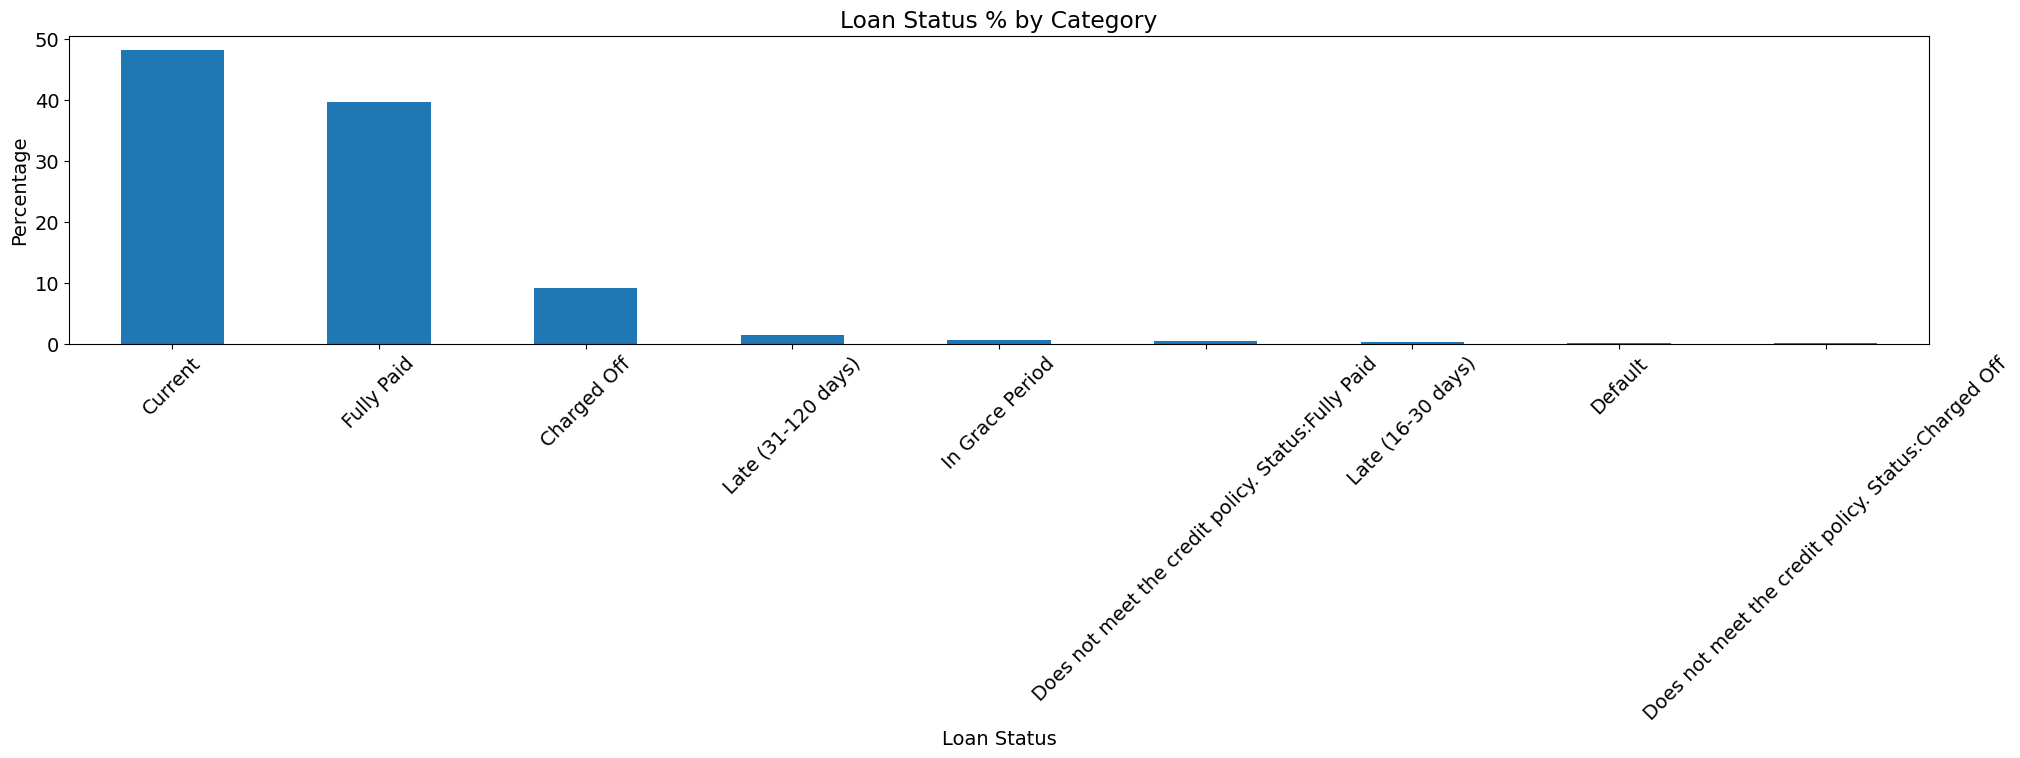

In [78]:
plt.figure()
plt.rcParams.update({'font.size': 14})
plt1 = (data['loan_status'].value_counts(normalize=True)*100).plot.bar(xlabel="Loan Status", title="Loan Status % by Category", rot=45, ylabel="Percentage",figsize=(24,4))

<p style="margin:10px; font-size: 15px"> Our next order of business is to enumerate the dependent variable, in this case "loan_status". For the sake of the model's interpretation, a "default" is considered an event. As such, defaulted loans are represented by "1".

In [79]:
labels = np.where(data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)','Does not meet the credit policy', 'Status:Charged Off']), 0, 1)
features = data.drop(columns="loan_status", inplace=False)

In [80]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,credit_card,AZ,27.65,0.0,Jan-85,1.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,861.07,Jan-15,171.62,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,car,GA,1.00,0.0,Apr-99,5.0,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,435.17,Apr-13,119.66,Sep-13,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,small_business,IL,8.72,0.0,Nov-01,2.0,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,603.65,Jun-14,649.91,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,other,CA,20.00,0.0,Feb-96,1.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,2209.33,Jan-15,357.48,Jan-15,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN
4,3000,3000,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,other,OR,17.94,0.0,Jan-96,0.0,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,1009.07,Jan-16,67.79,Jan-16,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN


In [81]:
def emp_length_key_cleaner(key):
    key = str(key)
    if('+ years' in key):
        return key.replace('+ years', '')
    if('< 1 year' in key):
        return str(0)
    if('n/a' in key):
        return str(0)
    if('years' in key):
        return key.replace(' years', '')
    if('year' in key):
        return key.replace(' year', '')
    return str(0)


def emp_length_field_cleaner(df, column):
    df[column] = df[column].apply(lambda k: emp_length_key_cleaner(k))
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)
    
    
def date_field_cleaner(df, column):
    today_date = pd.to_datetime('2020-08-01')
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    df.drop(columns = [column], inplace = True)
    df['mths_since_'+column].fillna(value = 0, inplace = True)
    
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))
    
emp_length_field_cleaner(features, 'emp_length')
date_field_cleaner(features, 'earliest_cr_line')
date_field_cleaner(features, 'issue_d')
date_field_cleaner(features, 'last_pymnt_d')
date_field_cleaner(features, 'last_credit_pull_d')
loan_term_converter(features, 'term')

<p style="margin:10px; font-size: 15px"> While there are specific pandas methods to deal with categorical data, there is some semi-numerical data in the form of dates that we will will clean up. As a mesure of time, we clearly do not want dates to be stored as categories. </p>

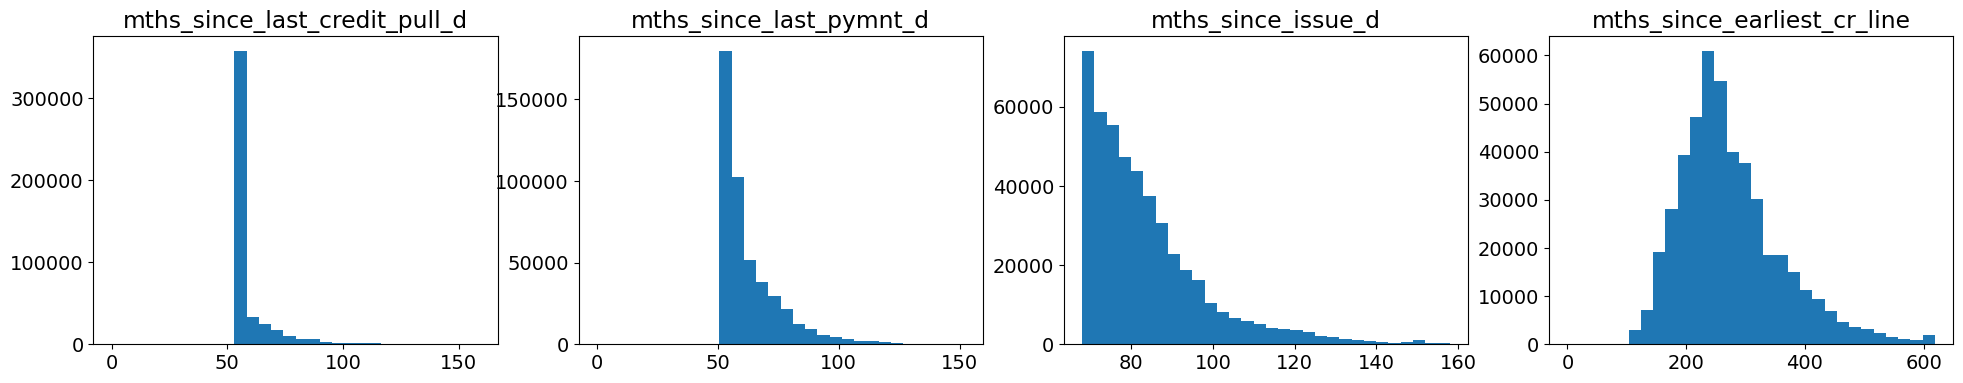

In [82]:
fig, axes_tuple = plt.subplots(1,4,figsize=(24,4))

for i,time_value_label in enumerate(('mths_since_last_credit_pull_d', 'mths_since_last_pymnt_d', 'mths_since_issue_d', 'mths_since_earliest_cr_line')):
    counts, bins = np.histogram(features[time_value_label],bins=30)
    axes_tuple[i].hist(bins[:-1], bins, weights=counts)
    axes_tuple[i].set_title(time_value_label)

<h3 style="text-align: center; color:#028ad9;">Part 2: Feature Selection</h3>


<p style="margin:10px; font-size: 15px"> We will perform several correlation tests on and between variables to decide which features we want to include in our model. For categorical data, we will use a Chi-Square test to measure the influence of certain features on the "loan_status" label. Doing so will allow us to only include variables significantly correlated with the outcome to reduce the eventual model's complexity. Models containing a large number of features are often prone to overfitting, so to avoid this, the top 4 categorical variables (by correlation) are selected. </p>


<p style="margin:10px; font-size: 15px"> An ANOVA test is used for the continuous features to determine the co-linearity of variable pairs. Again, we aim to reduce the complexity of the model so reducing redundant features is helpful.  </p>


<p style="margin:10px; font-size: 15px"> After selecting the top 24 features, the pandas get_dummies method is used to transform categorical features into binary ones. </p>

In [83]:
features.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
0,5000,5000,4975.0,36,10.65,162.87,B,10,RENT,24000.0,Verified,n,credit_card,AZ,27.65,0.0,1.0,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,861.07,171.62,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,427.0,104.0,67.0,55.0
1,2500,2500,2500.0,60,15.27,59.83,C,0,RENT,30000.0,Source Verified,n,car,GA,1.00,0.0,5.0,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,435.17,119.66,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,256.0,104.0,88.0,83.0
2,2400,2400,2400.0,36,15.96,84.33,C,10,RENT,12252.0,Not Verified,n,small_business,IL,8.72,0.0,2.0,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,603.65,649.91,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,225.0,104.0,74.0,55.0
3,10000,10000,10000.0,36,13.49,339.31,C,10,RENT,49200.0,Source Verified,n,other,CA,20.00,0.0,1.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,2209.33,357.48,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,294.0,104.0,67.0,67.0
4,3000,3000,3000.0,60,12.69,67.79,B,1,RENT,80000.0,Source Verified,n,other,OR,17.94,0.0,0.0,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,1009.07,67.79,0.0,1,INDIVIDUAL,0.0,NaN,NaN,NaN,295.0,104.0,55.0,55.0


In [84]:
categorical_features = features.select_dtypes(include = 'object').copy()
numerical_features = features.select_dtypes(exclude = 'object').copy()

categorical_features.shape

(466285, 8)

In [85]:
results = {"label":list(),"X2":list()}

for label in categorical_features:
    stat, pval, dof, expected_freq = chi2_contingency(pd.crosstab(labels, categorical_features[label]))
    results["label"].append(label)
    results["X2"].append(pval)

chi2_result = pd.DataFrame(data = results)
chi2_result.sort_values(by = ['X2'], ascending = True, ignore_index = True, inplace = True)

usable_cat_features = chi2_result['label'][0:4]

In [86]:
numerical_features.fillna(numerical_features.mean(), inplace = True)

F_statistic, p_values = f_classif(numerical_features, labels)

f_table = pd.DataFrame(data = {'Numerical_Feature': numerical_features.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
f_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

viable_features = f_table.iloc[:20,0]

vf_primary_list = viable_features.append(usable_cat_features).values

features = features[vf_primary_list]

In [87]:
pairwise_correlation_matrix = numerical_features[viable_features].corr()

multicollinear_features = list()

for feature in pairwise_correlation_matrix:
    possibly_critical = pairwise_correlation_matrix[feature].loc[pairwise_correlation_matrix[feature]>.99]
    for crit in possibly_critical.keys():
        if(crit != feature and (not(feature in multicollinear_features))):
            multicollinear_features.append(crit)

features.drop(columns=multicollinear_features, inplace=True)

In [88]:
# function to create dummy variables
def expand_categorical(df, columns):
    df_dummies = list()
    
    for col in columns:
        df_dummies.append(pd.get_dummies(df[col], prefix_sep = ':', prefix = col))
        
    additions = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, additions], axis = 1)
    
    return df

features = expand_categorical(features, ['grade', 'home_ownership', 'verification_status', 'purpose'])
features.drop(columns=features.select_dtypes(include="object").columns, inplace=True)
features.fillna(value={str(features.columns[i]) : features[str(features.columns[i])].mean() for i in range(len(features.columns))}, inplace=True)

<h3 style="text-align: center; color:#028ad9;">Part 3: Training the Model </h3>

<p style="margin:10px; font-size: 15px"> Now that the data is prepared, we will now move on to defining and training the model. Intuitively, we expect the features to be linearly related to the outcome. Thus a logistic regression is a reasonable choice. Furthermore, logistic regression will eliminate the possibility of a complex decision boundary which should increase the interpretability of the model. The sklearn pipeline is implemented for expandibility down the line. </p>

In [89]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42, stratify = labels)

In [90]:
model = LogisticRegression(max_iter=1000, class_weight = 'balanced')
naive_pipeline = Pipeline(steps=[('Regression Model',model)])

naive_pipeline.fit(X_train,y_train)

Pipeline(steps=[('Regression Model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

<p style="margin:10px; font-size: 15px">Now that the model is trained, its time to gain some intuition behind the results. We start by plotting the logistic regression coefficients (log scale). The values of these coefficients represent the weight that the model places on certain features, the higher they are the more important. </p>

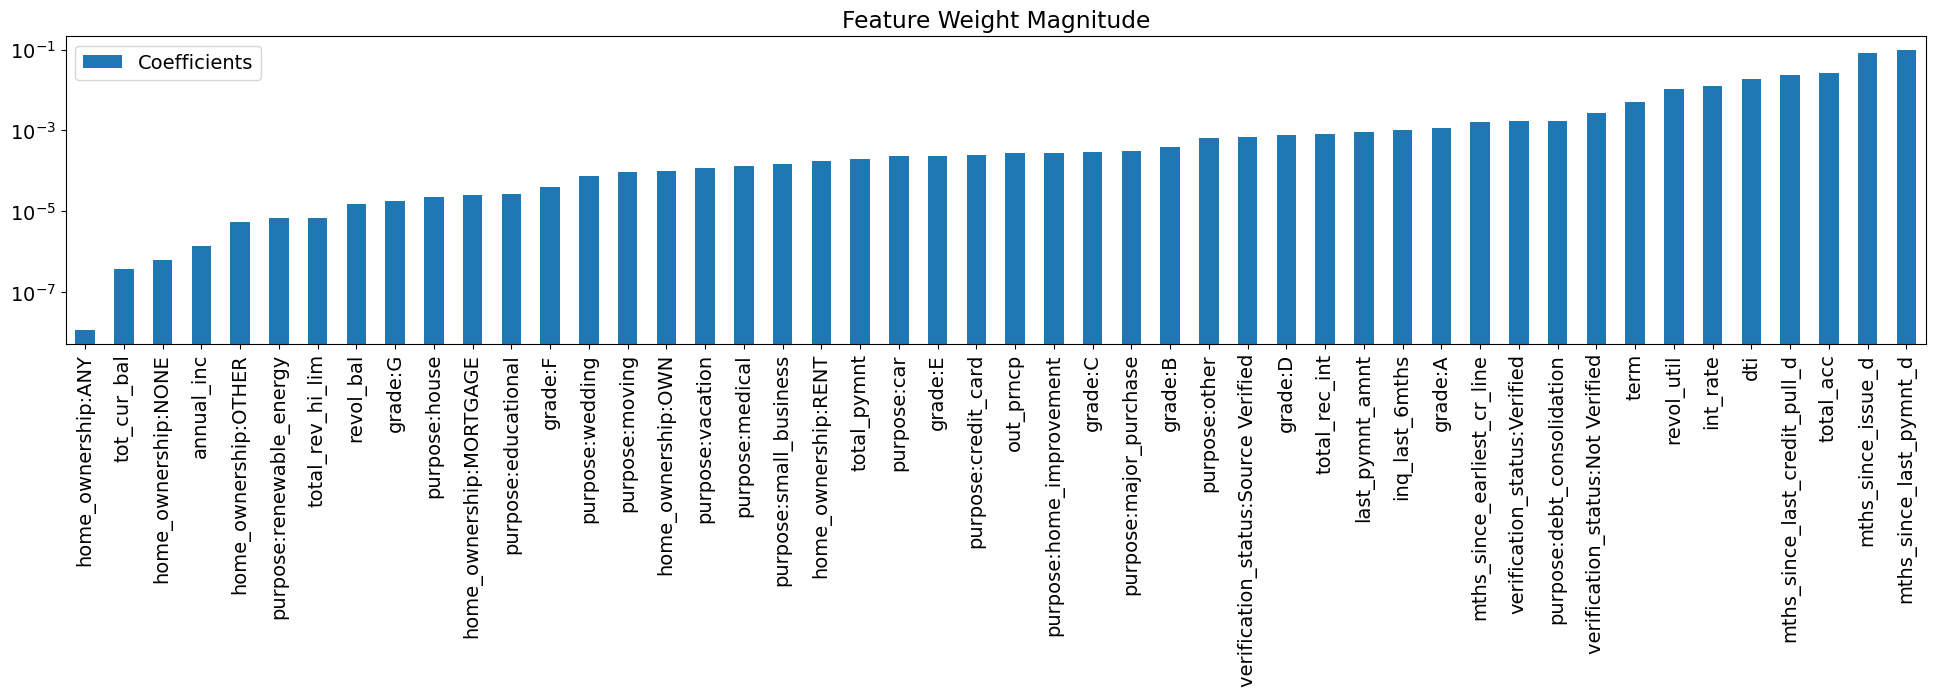

In [91]:
cdf = pd.DataFrame(model.coef_.T, X_train.columns, columns=['Coefficients']).apply(lambda x: (x**2)**(1/2)).sort_values(by=["Coefficients"])

fplot = cdf.plot.bar(figsize=(24,4),logy=True,title="Feature Weight Magnitude")


,Actually Positive,Actually Negative
Predicted Positive,0.081334,0.026336
Predicted Negative,0.038389,0.853941


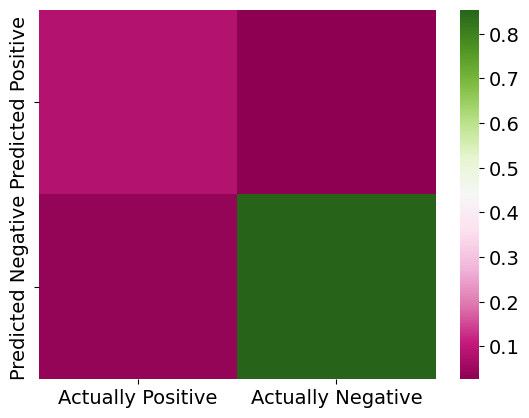

In [92]:
y_test=pd.DataFrame(y_test)
y_hat_test = naive_pipeline.predict(X_test)
y_hat_test_proba = naive_pipeline.predict_proba(X_test)
y_hat_test_proba = y_hat_test_proba[:][: , 1]

y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
y_test_proba.shape

y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
y_test_proba.index = X_test.index
y_test_proba.head()

tr = 0.3

y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
Cmatrix = pd.DataFrame(confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all'))

Cmatrix.set_axis(['Actually Positive','Actually Negative'], axis=1, inplace=True)
Cmatrix.set_axis(['Predicted Positive','Predicted Negative'], axis=0, inplace=True)

sns.heatmap(Cmatrix, cmap="PiYG")
Cmatrix

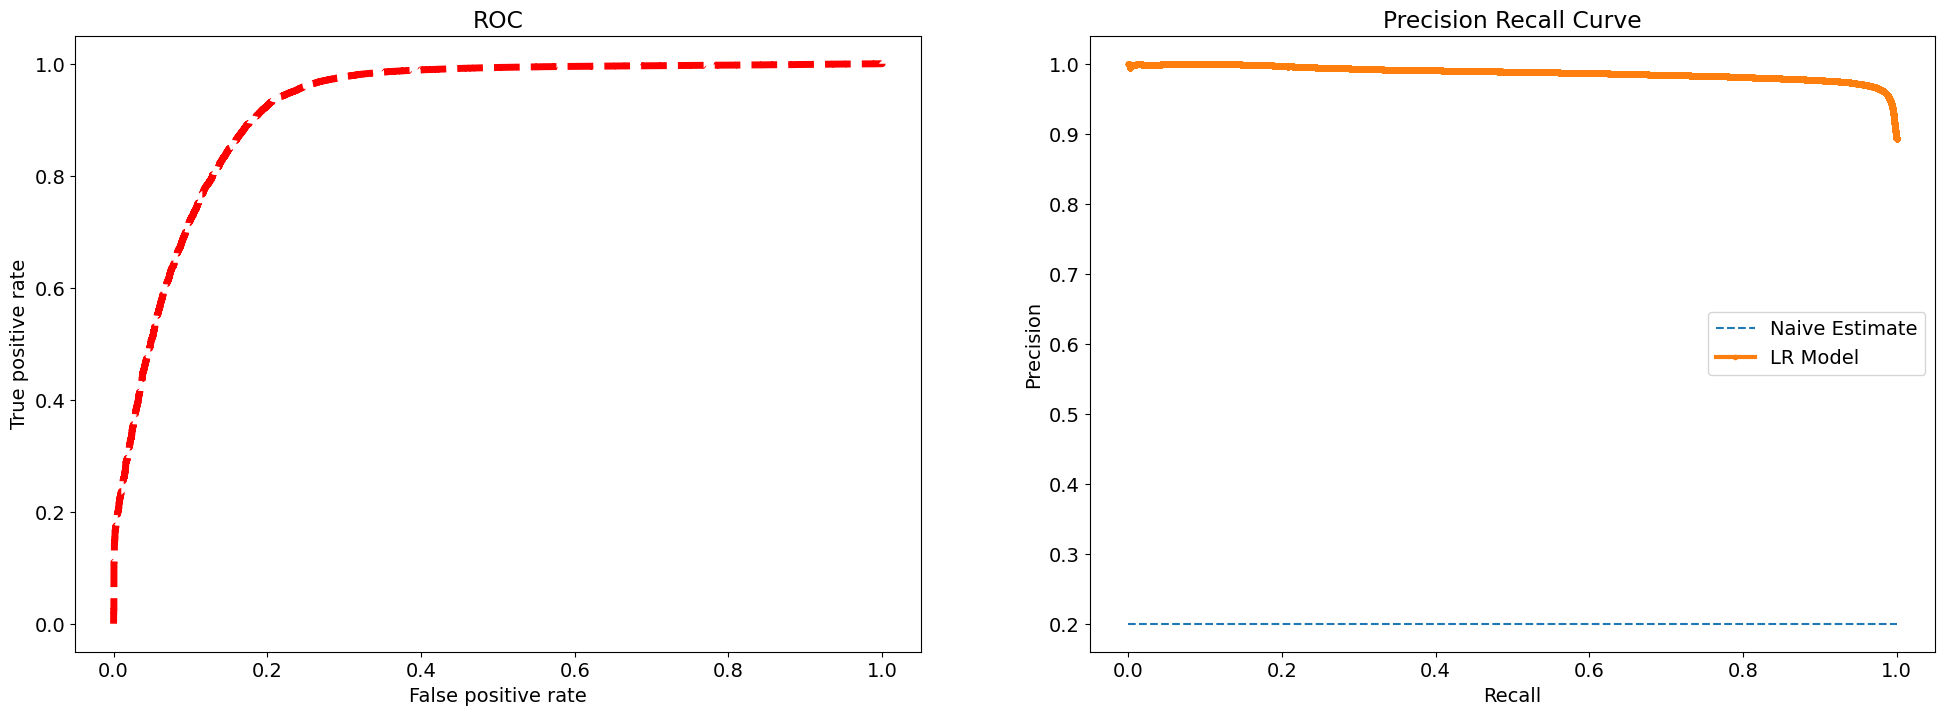

In [93]:
fig2, axes_tuple2 = plt.subplots(1,2,figsize=(24,8))


fp, tp, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
axes_tuple2[0].plot(fp, tp, linestyle = '--', color = 'red',linewidth=5)

axes_tuple2[0].set_xlabel('False positive rate')
axes_tuple2[0].set_ylabel('True positive rate')
axes_tuple2[0].set_title('ROC')

naive_test = len(y_test[y_test == 1]) / len(labels)

axes_tuple2[1].plot([0, 1], [naive_test, naive_test], linestyle='--', label='Naive Estimate')

precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
axes_tuple2[1].plot(recall, precision, marker='.', label='LR Model',linewidth=3)

axes_tuple2[1].set_xlabel('Recall')
axes_tuple2[1].set_ylabel('Precision')
axes_tuple2[1].legend()
axes_tuple2[1].set_title('Precision Recall Curve');

In [94]:
area_under_ROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
area_under_ROC

0.9240652601635735

Hey, thats pretty good!